In [3]:
import seaborn as sns
import pandas as pd
from pathlib import Path

In [4]:
results_path = Path("/Users/konsti/Library/CloudStorage/OneDrive-Personal/01_Education/Cambridge/PhD Docs/Own Publications/HEALNet/AAAI/results/healnet_aaai_results_v1.xlsx")

df_pivot = pd.read_excel(results_path, sheet_name="pivot", skiprows=4, header=[1,2])

In [5]:
df_raw = pd.read_excel(results_path, sheet_name="collection")

# replace "sources" strings
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["omic"\s*,\s*"slides"\]$', 'omic_slides', regex=True)
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["omic"\]$', 'omic', regex=True)
df_raw["sources"] = df_raw['sources'].str.replace(r'^\["slides"\]$', 'slides', regex=True)

df_raw["model"] = df_raw["model"].str.replace("healnet_early", "early fusion")

# Capitalize models and datasets (only first letter)
df_raw["model"] = df_raw["model"].str.upper()
df_raw["dataset"] = df_raw["dataset"].str.upper()

# drop duplicate [model, dataset, sources] combinations
df_raw.drop_duplicates(subset=["model", "dataset", "sources"], inplace=True)


In [6]:
# df_temp = df_raw.groupby(["dataset"]).agg({"mean_test_c_index": "mean", "std_test_c_index": "mean"})

# get best baseline by group
# df_baselines = df_raw[df_raw.sources != 'omic_slides'].groupby(["dataset", "model"], as_index=False).agg({"mean_test_c_index": "max"})
# get best baseline by dataset
df_baselines = df_raw[df_raw.sources != 'omic_slides'].groupby(["dataset"], as_index=False).agg({"mean_test_c_index": "max"})
df_baselines.rename(columns={"mean_test_c_index": "best_baseline"}, inplace=True)
df = pd.merge(df_raw, df_baselines, on=["dataset"], how="left")
# df = pd.merge(df_raw, df_baselines, on=["dataset", "model"], how="left")

# calculate uplift in % compared to best baseline
df["uplift"] = (df["mean_test_c_index"] - df["best_baseline"]) / df["best_baseline"] * 100
df = df[df.sources == "omic_slides"][["dataset", "model", "mean_test_c_index", "best_baseline", "uplift"]].dropna()
df.sort_values(by=["dataset", "uplift"], ascending=True, inplace=True)

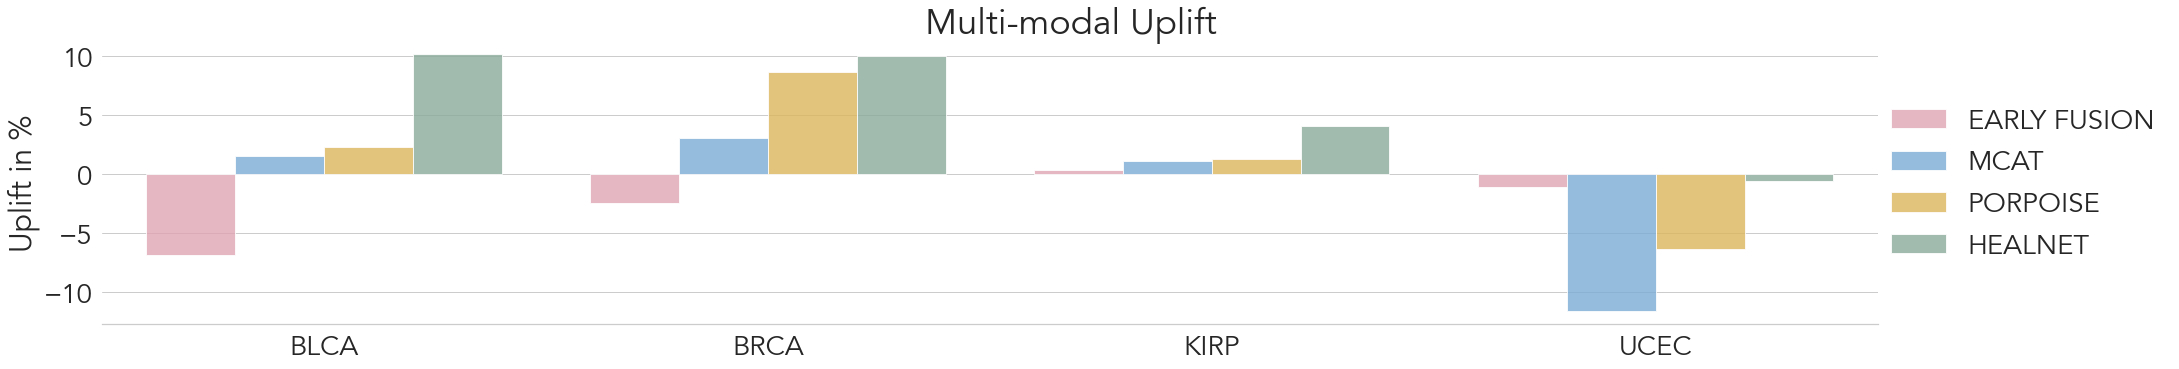

In [13]:
# google_palette = [
#     "#D32F2F", # blue 
#     "#1976D2", # red
#     "#FBC02D", # green 
#     "#388E3C", # yellow
#     "#8E24AA", # orange 
# ]

cambridge_palette = {
    "light": [
        "#E89CAE", # red
        "#6CACE4", # blue
        "#F1BE48", # orange
        "#85B09A",  # cambridge blue (real)
        "#B7BF10", # green
        "#AF95A6", # purple
              ], 
    "core": [
        "#D50032", # red
        "#0072CE", # blue
        "#E87722", # orange
        "#64A70B", # green
        "#93328E", # purple
        "#00B0B9" # cambridge blue
    ],  
    "dark": [
        "#A81538", # red
        "#003C71", # blue
        "#BE4D00", # orange
        "#4E5B31", # green
        "#3F2A56", # purple
        "#115E67" # cambridge blue
             ]
} 


save_path = Path("/Users/konsti/Library/CloudStorage/OneDrive-Personal/01_Education/Cambridge/PhD Docs/Own Publications/HEALNet/AAAI/figures")


def plot_mm_uplift(df, title):
    sns.set_theme(style="whitegrid", font="Avenir", font_scale=2.5, palette=cambridge_palette["light"])    
    g = sns.catplot(
        data=df, kind="bar",
        x="dataset", y="uplift", hue="model", alpha=0.8, height=6, 
        aspect=4.5 # increase for wider image
    )
    g.despine(left=True)
    g.set_axis_labels("", "Uplift in %")
    g.legend.set_title("")
    g.fig.suptitle(title)
    g.fig.subplots_adjust(top=0.9)
    g.savefig(save_path / "mm_uplift.png", dpi=300)
    
plot_mm_uplift(df, "Multi-modal Uplift")